In [ ]:
!pip install botorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 20.6 MB/s eta 0:00:00


In [ ]:
import os
import time
import copy
import warnings
from abc import ABC, abstractmethod

import torch
import matplotlib.pyplot as plt
%matplotlib inline

# GPyTorch imports
from gpytorch.mlls import ExactMarginalLogLikelihood

# BoTorch imports
from botorch.acquisition import AcquisitionFunction, AnalyticAcquisitionFunction, ExpectedImprovement, LogExpectedImprovement
from botorch.acquisition.utils import get_infeasible_cost
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.models.transforms import Log, Standardize
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.test_functions import Rosenbrock
from botorch.test_functions.synthetic import Hartmann
from botorch.test_functions.synthetic import Beale
from botorch.test_functions.synthetic import Bukin
from botorch.test_functions.synthetic import Powell
from botorch.test_functions.synthetic import ConstrainedGramacy
from botorch.utils import standardize
from botorch.utils.sampling import draw_sobol_samples, manual_seed
from botorch.generation.gen import gen_candidates_scipy


import torch

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}

# Define the synthetic objective and cost function
def synthetic_objective_with_cost(x):
    dim = 2
    f = Ackley(dim)  # synthetic objective is the Ackley
    fx = f(x).unsqueeze(1)
    # Quadratic synthetic cost function:
    cx = 200 * (1.1 - x[:, 0] - x[:, 1]) ** 2
    cx = cx.unsqueeze(1)
    return fx, cx

class CostModel(torch.nn.Module, ABC):
    """
    Simple abstract class for a cost model.
    """

    @abstractmethod
    def forward(self, X):
        pass

class CostModelGP(CostModel):
    """
    A basic cost model that assumes the cost is positive.
    It models the log cost to guarantee positive cost predictions.
    """

    def __init__(self, X, Y_cost):
        # Reshape Y_cost to [n, 1] to ensure it's 2-dimensional
        Y_cost = Y_cost.view(-1, 1)
        print("CostModelGP Y_cost.shape:", Y_cost.shape)  # Debug statement
        assert torch.all(Y_cost > 0), "All cost values must be positive."
        super().__init__()
        gp = SingleTaskGP(train_X=X, train_Y=Y_cost, outcome_transform=Log())
        mll = ExactMarginalLogLikelihood(likelihood=gp.likelihood, model=gp)
        fit_gpytorch_mll(mll)
        self.gp = gp

    def forward(self, X):
        return torch.exp(self.gp(X).mean)

class ExpectedImprovementWithCost(AnalyticAcquisitionFunction):
    """
    This is the acquisition function EI(x) / c(x)^alpha, where alpha is a decay
    factor that reduces or increases the emphasis of the cost model c(x).
    """

    def __init__(self, model, best_f, cost_model, alpha=1.0):
        super().__init__(model=model)
        self.model = model
        self.cost_model = cost_model
        self.ei = LogExpectedImprovement(model=model, best_f=best_f)
        self.alpha = alpha

    def forward(self, X):
        cost = self.cost_model(X).reshape(-1)
        return self.ei(X) / cost.pow(self.alpha)


class TwoStepLookaheadAcquisition(AcquisitionFunction):
    """
    A non-myopic acquisition function that implements a 2-step lookahead strategy.
    For each candidate point, we simulate sampling from the model to update the posterior
    and then plan one more step ahead, using an inner acquisition function (EI) to decide
    the next point after that. The expected improvement for both steps is averaged over
    multiple Monte Carlo samples from the posterior.

    This acquisition function incorporates cost by dividing the expected improvement
    by the predicted cost raised to a power alpha.
    """

    def __init__(self, model, cost_model, alpha=1.0, mc_samples=10, bounds=None):
        super().__init__(model=model)
        self.model = model
        self.cost_model = cost_model
        self.alpha = alpha
        self.mc_samples = mc_samples
        self.bounds = bounds

    def _simulate_next_step(self, X_candidate):
        """
        Simulate the next step after evaluating the candidate point X_candidate.
        """
        # Sample multiple outcomes for the objective
        posterior = self.model.posterior(X_candidate)
        posterior_mean = posterior.mean  # Extract the posterior mean

        improvements = []
        for _ in range(self.mc_samples):
            # Generate a noisy observation using the likelihood
            noisy_sample = self.model.likelihood(posterior_mean).rsample()  # [1, 1]

            # Construct the temporary training data
            temp_train_X = torch.cat([self.model.train_inputs[0], X_candidate.view(1, -1)], dim=0)  # [n+1, d]
            temp_train_Y = torch.cat([self.model.train_targets, noisy_sample.view(-1)], dim=0)     # [n+1]

            # Fit a temporary GP model for the objective
            temp_model = SingleTaskGP(
                train_X=temp_train_X,
                train_Y=temp_train_Y.view(-1, 1),
                outcome_transform=Standardize(m=1),
            )
            temp_mll = ExactMarginalLogLikelihood(temp_model.likelihood, temp_model)
            fit_gpytorch_mll(temp_mll)

            # Simulate the second step improvement using the fitted model
            temp_cost_model = CostModelGP(temp_train_X, self.cost_model(temp_train_X))
            best_f = temp_train_Y.min()
            inner_acq = ExpectedImprovementWithCost(
                model=temp_model,
                best_f=best_f,
                cost_model=temp_cost_model,
                alpha=self.alpha,
            )

            # Optimize the inner acquisition function
            next_x, _ = optimize_acqf(
                acq_function=inner_acq,
                bounds=self.bounds,
                q=1,
                num_restarts=5,
                raw_samples=1024,
            )

            # Evaluate the improvement
            next_posterior = temp_model.posterior(next_x)
            next_mean = next_posterior.mean
            current_best = temp_train_Y.min()
            improvement = current_best - next_mean.squeeze(-1)
            improvements.append(improvement)

        return torch.mean(torch.stack(improvements))


    def forward(self, X):
        """
        Evaluate the two-step lookahead acquisition function at points in X.
        For each candidate point in X, we compute:
        1. The immediate expected improvement (divided by cost^alpha).
        2. The expected improvement for the second step, computed by simulating
           the next step with updated model parameters.
        The total value is the sum of immediate and second-step improvements.
        """
        immediate_acq = ExpectedImprovementWithCost(
            model=self.model,
            best_f=self.model.train_targets.min(),
            cost_model=self.cost_model,
            alpha=self.alpha
        ).forward(X)

        # For the second step:
        # Here we approximate the second step improvement by simulating the model update
        # after taking X, then using an inner acquisition function (EI with cost) for the next step.
        # We'll do this by taking the average second-step improvement across multiple MC samples.

        second_step_improvement = []
        for i in range(X.shape[0]):
            # For each candidate point, simulate next step
            sim_improvement = self._simulate_next_step(X[i].unsqueeze(0))
            second_step_improvement.append(sim_improvement)
        second_step_improvement = torch.stack(second_step_improvement)

        # The total acquisition value is the sum of immediate and second-step improvements
        # adjusted for cost at the candidate.
        return immediate_acq + second_step_improvement

def bayesian_optimization_with_cost(
    init_X,
    init_Y,
    init_C,
    objective,
    cost_model_class,
    budget,
    bounds,
    initial_size,
    tkwargs,
    is_random=False,
    global_minimum=float("inf"),
    horizon=1,  # Additional parameter to specify lookahead horizon
):
    """
    Bayesian optimization loop with cost model, able to handle multi-step lookahead.
    """
    train_X = init_X
    train_Y = init_Y
    cost_Y = init_C
    accum_cost = 0.0
    train_Y_unstd = train_Y.clone()

    for i in range(budget):
        alpha = (budget - i - 1) / (budget - 1)

        # Train GP model for objective
        train_Y_flip = -1 * standardize(train_Y)
        gp = SingleTaskGP(train_X=train_X, train_Y=train_Y_flip)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        cost_model_gp = cost_model_class(train_X, cost_Y.reshape(cost_Y.shape[0], 1))

        if horizon == 1:
            # Acquisition function: Expected Improvement with cost
            fmax = torch.max(train_Y_flip)
            eipu = ExpectedImprovementWithCost(
                model=gp,
                cost_model=cost_model_gp,
                best_f=fmax,
                alpha=alpha,
            )

            # Optimize acquisition function to find next query point
            if not is_random:
                new_x, acq_value = optimize_acqf(
                    acq_function=eipu,
                    bounds=bounds,
                    q=1,
                    num_restarts=5,
                    raw_samples=1024,
                )
            else:
                # Randomly choose a new point
                lower_bounds = bounds[0, :]
                upper_bounds = bounds[1, :]
                d = len(bounds[0, :])
                new_x = lower_bounds + (upper_bounds - lower_bounds) * torch.rand(1, d)

        else:
            # Use the two-step lookahead acquisition function
            two_step_acq = TwoStepLookaheadAcquisition(
                model=gp,
                cost_model=cost_model_gp,
                alpha=alpha,
                mc_samples=10,
                bounds=bounds,
            )

            # Optimize the two-step lookahead acquisition function
            new_x, acq_value = optimize_acqf(
                acq_function=two_step_acq,
                bounds=bounds,
                q=1,
                num_restarts=5,
                raw_samples=1024,
                gen_candidates=gen_candidates_scipy,
                options={"method": "Nelder-Mead"},  # Use a derivative-free method
            )

        new_y, cost_y = objective(new_x.view(1, -1))
        accum_cost += cost_y

        # Update training data
        train_X = torch.cat([train_X, new_x])
        train_Y_unstd = torch.cat([train_Y_unstd, torch.tensor([new_y], **tkwargs).unsqueeze(1)])
        # cost_Y = torch.cat([cost_Y, torch.tensor([cost_y], **tkwargs).unsqueeze(1)])
        cost_Y = torch.cat([cost_Y, cost_y])

        train_Y = standardize(train_Y_unstd)
        global_minimum = min(global_minimum, new_y)

    # Calculate cumulative minimum of objective values (minimization) and cumulative costs
    # costs_eipu = cost_Y[initial_size-1:]
    results_ei_cost, _ = torch.cummin(train_Y_unstd, dim=0)
    results_ei_cost = results_ei_cost[initial_size-1:]
    times_ei_cost = torch.cumsum(cost_Y[initial_size-1:], dim=0)

    return train_X, results_ei_cost, times_ei_cost, accum_cost, global_minimum

# Define problem settings
dim = 2
bounds = torch.tensor([[0] * dim, [1] * dim], **tkwargs)
initial_size = 4

# Generate initial training data
with manual_seed(0):
    train_X = draw_sobol_samples(bounds=bounds, n=initial_size, q=1).squeeze(1)  # [n, d]
train_Y, cost_Y = synthetic_objective_with_cost(train_X)  # train_Y: [n,1], cost_Y: [n,1]

# Run Bayesian optimization with cost using horizon=1 (myopic) and horizon=2 (2-step lookahead)
print("Running Bayesian Optimization with cost (1-step myopic) ...")
results_1_step = bayesian_optimization_with_cost(
    init_X=train_X.clone(),
    init_Y=train_Y.clone(),
    init_C=cost_Y.clone(),
    objective=synthetic_objective_with_cost,
    cost_model_class=CostModelGP,
    budget=10,
    bounds=bounds,
    initial_size=initial_size,
    tkwargs=tkwargs,
    horizon=1,  # Myopic scenario
    is_random=False
)

train_X_1_step, results_ei_cost_1_step, times_ei_cost_1_step, accum_cost_1_step, global_minimum_1_step = results_1_step
print(global_minimum_1_step)
print("\nRunning Bayesian Optimization with cost (2-step lookahead) ...")
results_2_step = bayesian_optimization_with_cost(
    init_X=train_X.clone(),
    init_Y=train_Y.clone(),
    init_C=cost_Y.clone(),
    objective=synthetic_objective_with_cost,
    cost_model_class=CostModelGP,
    budget=10,
    bounds=bounds,
    initial_size=initial_size,
    tkwargs=tkwargs,
    horizon=2,  # 2-step lookahead
    is_random=False
)

# Extract results for plotting
train_X_1_step, results_ei_cost_1_step, times_ei_cost_1_step, accum_cost_1_step, global_minimum_1_step = results_1_step
train_X_2_step, results_ei_cost_2_step, times_ei_cost_2_step, accum_cost_2_step, global_minimum_2_step = results_2_step

# Plotting results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(times_ei_cost_1_step.detach().numpy(), results_ei_cost_1_step.detach().numpy(), label='1-step Myopic')
plt.plot(times_ei_cost_2_step.detach().numpy(), results_ei_cost_2_step.detach().numpy(), label='2-step Lookahead')
plt.xlabel("Cumulative Cost")
plt.ylabel("Best Objective Value")
plt.title("Objective Value vs. Cumulative Cost")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(initial_size, initial_size + 10), results_ei_cost_1_step.detach().numpy(), label='1-step Myopic')
plt.plot(range(initial_size, initial_size + 10), results_ei_cost_2_step.detach().numpy(), label='2-step Lookahead')
plt.xlabel("Iteration")
plt.ylabel("Best Objective Value")
plt.title("Objective Value vs. Iterations")
plt.legend()

plt.tight_layout()
plt.show()


Running Bayesian Optimization with cost (1-step myopic) ...
CostModelGP Y_cost.shape: torch.Size([4, 1])


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.9884], dtype=torch.float64), mean = tensor([2.8856], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


CostModelGP Y_cost.shape: torch.Size([5, 1])


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.7272], dtype=torch.float64), mean = tensor([3.2703], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


CostModelGP Y_cost.shape: torch.Size([6, 1])


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.5448], dtype=torch.float64), mean = tensor([3.5663], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


CostModelGP Y_cost.shape: torch.Size([7, 1])


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.4199], dtype=torch.float64), mean = tensor([3.8225], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


CostModelGP Y_cost.shape: torch.Size([8, 1])


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.3164], dtype=torch.float64), mean = tensor([4.0305], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


CostModelGP Y_cost.shape: torch.Size([9, 1])


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.2206], dtype=torch.float64), mean = tensor([4.1925], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


CostModelGP Y_cost.shape: torch.Size([10, 1])


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.1334], dtype=torch.float64), mean = tensor([4.3222], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


CostModelGP Y_cost.shape: torch.Size([11, 1])


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.3008], dtype=torch.float64), mean = tensor([3.9923], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


CostModelGP Y_cost.shape: torch.Size([12, 1])


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.2358], dtype=torch.float64), mean = tensor([4.1170], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


CostModelGP Y_cost.shape: torch.Size([13, 1])


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.1647], dtype=torch.float64), mean = tensor([4.0277], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


tensor([[4.4409e-16]], dtype=torch.float64)

Running Bayesian Optimization with cost (2-step lookahead) ...
CostModelGP Y_cost.shape: torch.Size([4, 1])


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.9884], dtype=torch.float64), mean = tensor([2.8856], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
import os
import time
import copy
import warnings
from abc import ABC, abstractmethod

import torch
import matplotlib.pyplot as plt
%matplotlib inline

# GPyTorch imports
from gpytorch.mlls import ExactMarginalLogLikelihood

# BoTorch imports
from botorch.acquisition import AcquisitionFunction, AnalyticAcquisitionFunction, ExpectedImprovement, LogExpectedImprovement
from botorch.acquisition.utils import get_infeasible_cost
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.models.transforms import Log, Standardize
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.test_functions import Rosenbrock
from botorch.test_functions.synthetic import Hartmann
from botorch.test_functions.synthetic import Beale
from botorch.test_functions.synthetic import Bukin
from botorch.test_functions.synthetic import Powell
from botorch.test_functions.synthetic import ConstrainedGramacy
from botorch.utils import standardize
from botorch.utils.sampling import draw_sobol_samples, manual_seed
from botorch.generation.gen import gen_candidates_scipy


import torch

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}

# Define the synthetic objective and cost function
def synthetic_objective_with_cost(x):
    dim = 2
    f = Ackley(dim)  # synthetic objective is the Ackley
    fx = f(x).unsqueeze(1)
    # Quadratic synthetic cost function:
    cx = 200 * (1.1 - x[:, 0] - x[:, 1]) ** 2
    cx = cx.unsqueeze(1)
    return fx, cx

class CostModel(torch.nn.Module, ABC):
    """
    Simple abstract class for a cost model.
    """

    @abstractmethod
    def forward(self, X):
        pass

class CostModelGP(CostModel):
    """
    A basic cost model that assumes the cost is positive.
    It models the log cost to guarantee positive cost predictions.
    """

    def __init__(self, X, Y_cost):
        # Reshape Y_cost to [n, 1] to ensure it's 2-dimensional
        Y_cost = Y_cost.view(-1, 1)
        print("CostModelGP Y_cost.shape:", Y_cost.shape)  # Debug statement
        assert torch.all(Y_cost > 0), "All cost values must be positive."
        super().__init__()
        gp = SingleTaskGP(train_X=X, train_Y=Y_cost, outcome_transform=Log())
        mll = ExactMarginalLogLikelihood(likelihood=gp.likelihood, model=gp)
        fit_gpytorch_mll(mll)
        self.gp = gp

    def forward(self, X):
        return torch.exp(self.gp(X).mean)

class ExpectedImprovementWithCost(AnalyticAcquisitionFunction):
    """
    This is the acquisition function EI(x) / c(x)^alpha, where alpha is a decay
    factor that reduces or increases the emphasis of the cost model c(x).
    """

    def __init__(self, model, best_f, cost_model, alpha=1.0):
        super().__init__(model=model)
        self.model = model
        self.cost_model = cost_model
        self.ei = LogExpectedImprovement(model=model, best_f=best_f)
        self.alpha = alpha

    def forward(self, X):
        cost = self.cost_model(X).reshape(-1)
        return self.ei(X) / cost.pow(self.alpha)


class TwoStepLookaheadAcquisition(AcquisitionFunction):
    """
    A non-myopic acquisition function that implements a 2-step lookahead strategy.
    For each candidate point, we simulate sampling from the model to update the posterior
    and then plan one more step ahead, using an inner acquisition function (EI) to decide
    the next point after that. The expected improvement for both steps is averaged over
    multiple Monte Carlo samples from the posterior.

    This acquisition function incorporates cost by dividing the expected improvement
    by the predicted cost raised to a power alpha.
    """

    def __init__(self, model, cost_model, alpha=1.0, mc_samples=10, bounds=None):
        super().__init__(model=model)
        self.model = model
        self.cost_model = cost_model
        self.alpha = alpha
        self.mc_samples = mc_samples
        self.bounds = bounds

    def _simulate_next_step(self, X_candidate):
        """
        Simulate the next step after evaluating the candidate point X_candidate.
        """
        # Extract current training data
        train_X = self.model.train_inputs[0]
        train_Y = self.model.train_targets

        # Get the posterior mean at X_candidate
        posterior = self.model.posterior(X_candidate)
        posterior_mean = posterior.mean  # Shape: [1, 1]

        improvements = []
        for _ in range(self.mc_samples):
            # Generate a noisy observation using the model's likelihood
            # This sample depends on model parameters
            noisy_sample = self.model.likelihood(posterior_mean).rsample()  # Shape: [1, 1]

            # Construct the temporary training data
            temp_train_X = torch.cat([train_X, X_candidate.view(1, -1)], dim=0)
            temp_train_Y = torch.cat([train_Y.view(-1, 1), noisy_sample.view(-1, 1)], dim=0)  # Both are [n, 1]


            # Do not detach temp_train_Y to keep the computational graph
            # temp_train_X = temp_train_X.detach()
            temp_train_X.requires_grad_(False)
            temp_train_Y.requires_grad_(False)

            # Standardize temp_train_Y externally
            standardized_temp_train_Y = standardize(temp_train_Y)

            # Initialize the GP model without an outcome_transform
            temp_model = SingleTaskGP(
                train_X=temp_train_X,
                train_Y=standardized_temp_train_Y,
            )

            print(train_X)
            print(train_Y)
            print(temp_train_X)
            print(standardized_temp_train_Y)

            temp_mll = ExactMarginalLogLikelihood(temp_model.likelihood, temp_model)

            # Ensure model parameters require gradients
            # for name, param in temp_model.named_parameters():
            #     param.requires_grad_(True)

            # Set the model to training mode
            temp_model.train()
            temp_model.likelihood.train()

            # Compute loss and check requires_grad
            output = temp_model(temp_train_X)
            loss = -temp_mll(output, standardized_temp_train_Y)
            print("Loss value:", loss)
            print("Loss requires grad:", loss.requires_grad)
            loss.requires_grad_(True)
            if not loss.requires_grad:
                raise RuntimeError("Loss does not require grad. Cannot proceed with backpropagation.")


            print(temp_mll)

            # Fit the GP model
            fit_gpytorch_mll(temp_mll)

            # Simulate the next step with the temporary model
            temp_cost_model = CostModelGP(temp_train_X, self.cost_model(temp_train_X))
            best_f = temp_train_Y.min()
            inner_acq = ExpectedImprovementWithCost(
                model=temp_model,
                best_f=best_f,
                cost_model=temp_cost_model,
                alpha=self.alpha
            )

            # Optimize the inner acquisition function
            next_x, _ = optimize_acqf(
                acq_function=inner_acq,
                bounds=self.bounds,
                q=1,
                num_restarts=5,
                raw_samples=1024,
            )

            # Evaluate the improvement
            next_posterior = temp_model.posterior(next_x)
            next_mean = next_posterior.mean  # Shape: [1, 1]
            current_best = temp_train_Y.min()  # Scalar
            improvement = current_best - next_mean.squeeze(-1)  # Scalar
            improvements.append(improvement)

        return torch.mean(torch.stack(improvements))





    def forward(self, X):
        """
        Evaluate the two-step lookahead acquisition function at points in X.
        For each candidate point in X, we compute:
        1. The immediate expected improvement (divided by cost^alpha).
        2. The expected improvement for the second step, computed by simulating
           the next step with updated model parameters.
        The total value is the sum of immediate and second-step improvements.
        """
        immediate_acq = ExpectedImprovementWithCost(
            model=self.model,
            best_f=self.model.train_targets.min(),
            cost_model=self.cost_model,
            alpha=self.alpha
        ).forward(X)

        # For the second step:
        # Here we approximate the second step improvement by simulating the model update
        # after taking X, then using an inner acquisition function (EI with cost) for the next step.
        # We'll do this by taking the average second-step improvement across multiple MC samples.

        second_step_improvement = []
        for i in range(X.shape[0]):
            # For each candidate point, simulate next step
            sim_improvement = self._simulate_next_step(X[i].unsqueeze(0))
            second_step_improvement.append(sim_improvement)
        second_step_improvement = torch.stack(second_step_improvement)

        # The total acquisition value is the sum of immediate and second-step improvements
        # adjusted for cost at the candidate.
        return immediate_acq + second_step_improvement

def bayesian_optimization_with_cost(
    init_X,
    init_Y,
    init_C,
    objective,
    cost_model_class,
    budget,
    bounds,
    initial_size,
    tkwargs,
    is_random=False,
    global_minimum=float("inf"),
    horizon=1,  # Additional parameter to specify lookahead horizon
):
    """
    Bayesian optimization loop with cost model, able to handle multi-step lookahead.
    """
    train_X = init_X
    train_Y = init_Y
    cost_Y = init_C
    accum_cost = 0.0
    train_Y_unstd = train_Y.clone()

    for i in range(budget):
        alpha = (budget - i - 1) / (budget - 1)

        # Train GP model for objective
        train_Y_flip = -1 * standardize(train_Y)
        gp = SingleTaskGP(train_X=train_X, train_Y=train_Y_flip)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        cost_model_gp = cost_model_class(train_X, cost_Y.reshape(cost_Y.shape[0], 1))

        if horizon == 1:
            # Acquisition function: Expected Improvement with cost
            fmax = torch.max(train_Y_flip)
            eipu = ExpectedImprovementWithCost(
                model=gp,
                cost_model=cost_model_gp,
                best_f=fmax,
                alpha=alpha,
            )

            # Optimize acquisition function to find next query point
            if not is_random:
                new_x, acq_value = optimize_acqf(
                    acq_function=eipu,
                    bounds=bounds,
                    q=1,
                    num_restarts=5,
                    raw_samples=1024,
                )
            else:
                # Randomly choose a new point
                lower_bounds = bounds[0, :]
                upper_bounds = bounds[1, :]
                d = len(bounds[0, :])
                new_x = lower_bounds + (upper_bounds - lower_bounds) * torch.rand(1, d)

        else:
            # Use the two-step lookahead acquisition function
            two_step_acq = TwoStepLookaheadAcquisition(
                model=gp,
                cost_model=cost_model_gp,
                alpha=alpha,
                mc_samples=10,
                bounds=bounds,
            )

            # Optimize the two-step lookahead acquisition function
            new_x, acq_value = optimize_acqf(
                acq_function=two_step_acq,
                bounds=bounds,
                q=1,
                num_restarts=5,
                raw_samples=1024,
                gen_candidates=gen_candidates_scipy,
                options={"method": "Nelder-Mead"},  # Use a derivative-free method
            )

        new_y, cost_y = objective(new_x.view(1, -1))
        accum_cost += cost_y

        # Update training data
        train_X = torch.cat([train_X, new_x])
        train_Y_unstd = torch.cat([train_Y_unstd, torch.tensor([new_y], **tkwargs).unsqueeze(1)])
        # cost_Y = torch.cat([cost_Y, torch.tensor([cost_y], **tkwargs).unsqueeze(1)])
        cost_Y = torch.cat([cost_Y, cost_y])

        train_Y = standardize(train_Y_unstd)
        global_minimum = min(global_minimum, new_y)

    # Calculate cumulative minimum of objective values (minimization) and cumulative costs
    # costs_eipu = cost_Y[initial_size-1:]
    results_ei_cost, _ = torch.cummin(train_Y_unstd, dim=0)
    results_ei_cost = results_ei_cost[initial_size-1:]
    times_ei_cost = torch.cumsum(cost_Y[initial_size-1:], dim=0)

    return train_X, results_ei_cost, times_ei_cost, accum_cost, global_minimum

# Define problem settings
dim = 2
bounds = torch.tensor([[0] * dim, [1] * dim], **tkwargs)
initial_size = 4

# Generate initial training data
with manual_seed(0):
    train_X = draw_sobol_samples(bounds=bounds, n=initial_size, q=1).squeeze(1)  # [n, d]
train_Y, cost_Y = synthetic_objective_with_cost(train_X)  # train_Y: [n,1], cost_Y: [n,1]

# Run Bayesian optimization with cost using horizon=1 (myopic) and horizon=2 (2-step lookahead)
# print("Running Bayesian Optimization with cost (1-step myopic) ...")
# results_1_step = bayesian_optimization_with_cost(
#     init_X=train_X.clone(),
#     init_Y=train_Y.clone(),
#     init_C=cost_Y.clone(),
#     objective=synthetic_objective_with_cost,
#     cost_model_class=CostModelGP,
#     budget=10,
#     bounds=bounds,
#     initial_size=initial_size,
#     tkwargs=tkwargs,
#     horizon=1,  # Myopic scenario
#     is_random=False
# )

print("\nRunning Bayesian Optimization with cost (2-step lookahead) ...")
results_2_step = bayesian_optimization_with_cost(
    init_X=train_X.clone(),
    init_Y=train_Y.clone(),
    init_C=cost_Y.clone(),
    objective=synthetic_objective_with_cost,
    cost_model_class=CostModelGP,
    budget=10,
    bounds=bounds,
    initial_size=initial_size,
    tkwargs=tkwargs,
    horizon=2,  # 2-step lookahead
    is_random=False
)

# Extract results for plotting
train_X_1_step, results_ei_cost_1_step, times_ei_cost_1_step, accum_cost_1_step, global_minimum_1_step = results_1_step
train_X_2_step, results_ei_cost_2_step, times_ei_cost_2_step, accum_cost_2_step, global_minimum_2_step = results_2_step

# Plotting results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(times_ei_cost_1_step.detach().numpy(), results_ei_cost_1_step.detach().numpy(), label='1-step Myopic')
plt.plot(times_ei_cost_2_step.detach().numpy(), results_ei_cost_2_step.detach().numpy(), label='2-step Lookahead')
plt.xlabel("Cumulative Cost")
plt.ylabel("Best Objective Value")
plt.title("Objective Value vs. Cumulative Cost")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(initial_size, initial_size + 10), results_ei_cost_1_step.detach().numpy(), label='1-step Myopic')
plt.plot(range(initial_size, initial_size + 10), results_ei_cost_2_step.detach().numpy(), label='2-step Lookahead')
plt.xlabel("Iteration")
plt.ylabel("Best Objective Value")
plt.title("Objective Value vs. Iterations")
plt.legend()

plt.tight_layout()
plt.show()



Running Bayesian Optimization with cost (2-step lookahead) ...
CostModelGP Y_cost.shape: torch.Size([4, 1])


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.9884], dtype=torch.float64), mean = tensor([2.8856], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


tensor([[0.4751, 0.5925],
        [0.5788, 0.0371],
        [0.9507, 0.8623],
        [0.1205, 0.2614]], dtype=torch.float64)
tensor([-1.0176,  0.1461, -0.4484,  1.3199], dtype=torch.float64)
tensor([[0.4751, 0.5925],
        [0.5788, 0.0371],
        [0.9507, 0.8623],
        [0.1205, 0.2614],
        [0.9722, 0.3708]], dtype=torch.float64)
tensor([[-1.1295],
        [ 0.2087],
        [-0.4750],
        [ 1.5584],
        [-0.1626]], dtype=torch.float64)
Loss value: tensor([1.2821, 0.8854, 0.9440, 1.6533, 0.8799], dtype=torch.float64)
Loss requires grad: False
ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_modu

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
# Sample data
X_sample = torch.randn(5, 2, dtype=torch.double)
Y_sample = torch.randn(5, 1, dtype=torch.double)


X_sample.requires_grad_(False)
Y_sample.requires_grad_(False)


mean = Y_sample.mean(dim=0, keepdim=True)
std = Y_sample.std(dim=0, keepdim=True)
Y_sample_standardized = (Y_sample - mean) / std



print(X_sample)
print(Y_sample)
print(Y_sample_standardized)

gp_model = SingleTaskGP(train_X=X_sample, train_Y=Y_sample_standardized)
gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)


for param in gp_model.parameters():
    param.requires_grad_(True)

output = gp_model(X_sample)
loss = -gp_mll(output, Y_sample_standardized)
print("Loss value:", loss)
print("Loss requires grad:", loss.requires_grad)

# Fit model
print(gp_mll)
fit_gpytorch_mll(gp_mll)


tensor([[-1.2965,  0.6470],
        [ 0.9830,  0.6985],
        [ 1.1308,  1.8944],
        [ 0.1718, -0.6236],
        [-1.0959, -0.4904]], dtype=torch.float64)
tensor([[-0.7506],
        [-0.7791],
        [-0.5126],
        [-1.0701],
        [ 0.2061]], dtype=torch.float64)
tensor([[-0.3509],
        [-0.4100],
        [ 0.1422],
        [-1.0129],
        [ 1.6317]], dtype=torch.float64)
Loss value: tensor([0.9588, 0.9812, 0.9077, 1.4072, 2.2197], dtype=torch.float64,
       grad_fn=<NegBackward0>)
Loss requires grad: True
ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_modu

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (lengthscale_prior): LogNormalPrior()
      (raw_lengthscale_constraint): GreaterThan(2.500E-02)
    )
    (outcome_transform): Standardize()
  )
)

In [ ]:
!git clone https://github.com/erichanslee/lookahead_release.git

Cloning into 'lookahead_release'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 66 (delta 17), reused 57 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 606.34 KiB | 2.33 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [ ]:
# rollout_ei_with_cost.py

import numpy as np
import multiprocessing as mp
import copy
import time
from lookahead_release.lookahead.acquisitions.acquisition_function_interface import AcquisitionFunctionInterface
from lookahead_release.lookahead.acquisitions.expected_improvement import ExpectedImprovement
from lookahead_release.lookahead.acquisitions.acquisition_optimizer_bo import BayesOptAcquisitionOptimizer

class RolloutEIWithCost(AcquisitionFunctionInterface):
    """
    A class for calculating the sequential rewards of MDP BayesOpt with cost constraints
    via parallel MC.
    """

    def __init__(self, gaussian_process, cost_model, opt_domain, horizon, mc_iters=int(1e2), opt_mode='grad', alpha=1.0):
        super().__init__(gaussian_process, opt_domain)
        self.cost_model = cost_model
        self.horizon = horizon
        self.mc_iters = mc_iters
        self.numthreads = int(mp.cpu_count()/2)
        self.opt_mode = opt_mode
        self.alpha = alpha

    def evaluate_at_point_list(self, points_to_evaluate):
        num_points = points_to_evaluate.shape[0]
        rollout_values = np.zeros(num_points)
        for i in range(num_points):
            rollout_values[i] = self._evaluate_at_point(points_to_evaluate[[i], :])
        return rollout_values

    def _evaluate_at_point(self, point_to_evaluate):
        self.point_current = point_to_evaluate

        if self.numthreads > 1:
            serial_mc_iters = [int(self.mc_iters/self.numthreads)] * self.numthreads
            pool = mp.Pool(processes=self.numthreads)
            rewards = pool.map(self._evaluate_point_serial, serial_mc_iters)
            pool.close()
            pool.join()
        else:
            rewards = [self._evaluate_point_serial(self.mc_iters)]

        return np.sum(rewards) / self.numthreads

    def _evaluate_point_serial(self, mc_iters):
        reward = 0
        for _ in range(mc_iters):
            r = self.draw_from_policy(self.point_current)
            reward += r
        return reward / mc_iters

    def draw_from_policy(self, point_to_evaluate):
        reward = 0
        gp_temp = copy.deepcopy(self.gaussian_process)
        cost_model_temp = copy.deepcopy(self.cost_model)
        xi = point_to_evaluate
        h = self.horizon
        i = 0

        while True:
            np.random.seed(int(time.time()))
            fi = gp_temp.sample_single(xi)
            ci = cost_model_temp.sample_single(xi)
            ri = self.reward(gp_temp, fi, ci)
            reward += ri
            i += 1
            h -= 1
            if h <= 0:
                break

            gp_temp.chol_update(xi, fi)
            cost_model_temp.chol_update(xi, ci)

            # Define inner acquisition function with cost
            ei_with_cost = ExpectedImprovementWithCost(gp_temp, cost_model_temp, self.opt_domain, alpha=self.alpha)

            if self.opt_mode == 'grad':
                xi = ei_with_cost.next_point_grad()
            else:
                xi = ei_with_cost.next_point_grid()
        return reward

    def reward(self, gp, fi, ci):
        _, ytrain = gp.get_historical_data()
        ymin = np.min(ytrain)
        # Adjust reward by cost penalty
        r = max(ymin - float(fi), 0) / (ci ** self.alpha)
        return r

    def next_point(self):
        optimizer = BayesOptAcquisitionOptimizer(self.gaussian_process, self.evaluate_at_point_list, self.opt_domain)
        return optimizer.get_sample_point()


In [ ]:
# expected_improvement_with_cost.py

from lookahead_release.lookahead.acquisitions.acquisition_function_interface import AcquisitionFunctionInterface
from scipy.stats import norm
import numpy as np

class ExpectedImprovementWithCost(AcquisitionFunctionInterface):
    """
    Expected Improvement acquisition function adjusted by the cost model.
    EI(x) / c(x)^alpha
    """

    def __init__(self, gaussian_process, cost_model, opt_domain, alpha=1.0):
        super().__init__(gaussian_process, opt_domain)
        self.cost_model = cost_model
        self.alpha = alpha

    def evaluate_at_point_list(self, points_to_evaluate):
        mu = self.gaussian_process.mean(points_to_evaluate)
        sigma2 = self.gaussian_process.variance(points_to_evaluate)
        sigma = np.sqrt(sigma2)

        mu_c = self.cost_model.mean(points_to_evaluate)
        # Ensure positive cost predictions
        mu_c = np.maximum(mu_c, 1e-6)

        xhist, yhist = self.gaussian_process.get_historical_data()
        fmin = np.min(yhist)
        z = (fmin - mu) / sigma
        cdf_z = norm.cdf(z)
        pdf_z = norm.pdf(z)
        ei = sigma * np.fmax(0.0, z * cdf_z + pdf_z)
        return ei / (mu_c ** self.alpha)

    def joint_function_gradient_eval(self, points_to_evaluate):
        # Implement gradient computation if needed
        pass

    def next_point(self):
        return self.next_point_grad()


In [ ]:
import numpy as np
from lookahead_release.lookahead.model.gaussian_process import GaussianProcessSimple
from lookahead_release.lookahead.model.historical_data import HistoricalData
# from lookahead_release.lookahead.model.covariance import SquaredExponential
from lookahead_release.lookahead.acquisitions.rollout_ei_with_cost import RolloutEIWithCost
import numpy as np

class SquaredExponential:
    def __init__(self, dim, ls=1.0):
        self.dim = dim
        self.ls = ls  # Length scale

    def covariance(self, X1, X2):
        # Compute the squared distance
        dists = np.sum((X1[:, None, :] - X2[None, :, :])**2, axis=-1)
        # Compute the kernel
        return np.exp(-0.5 * dists / self.ls**2)

    def build_kernel_matrix(self, X, points_to_sample=None, noise_variance=None):
        if points_to_sample is None:
            points_to_sample = X
        kernel_matrix = self.covariance(X, points_to_sample)
        if noise_variance is not None:
            np.fill_diagonal(kernel_matrix, kernel_matrix.diagonal() + noise_variance)
        return kernel_matrix

# Define your synthetic objective and cost functions
def synthetic_objective_with_cost_np(x):
    # Ensure x is 2D array
    x = np.atleast_2d(x)
    dim = x.shape[1]
    # Ackley function
    fx = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x[:, 0]**2 + x[:, 1]**2))) - \
         np.exp(0.5 * (np.cos(2 * np.pi * x[:, 0]) + np.cos(2 * np.pi * x[:, 1]))) + np.e + 20
    fx = fx.reshape(-1, 1)
    # Quadratic cost function
    cx = 200 * (1.1 - x[:, 0] - x[:, 1]) ** 2
    cx = cx.reshape(-1, 1)
    return fx, cx

# Initialize GP models for objective and cost
def initialize_gp_models(X_init, Y_init, C_init):
    # Objective GP
    cov = SquaredExponential(dim=X_init.shape[1], ls=1.0)
    hd = HistoricalData(X_init, Y_init)
    gp_obj = GaussianProcessSimple(hd, cov)
    gp_obj.train()

    # Cost GP
    cov_c = SquaredExponential(dim=X_init.shape[1], ls=1.0)
    hd_c = HistoricalData(X_init, C_init)
    gp_cost = GaussianProcessSimple(hd_c, cov_c)
    gp_cost.train()

    return gp_obj, gp_cost

# Main optimization loop
def bayesian_optimization_with_cost(horizon, budget, opt_domain, alpha=1.0):
    # Generate initial data
    X_init = opt_domain.generate_quasi_random_points_in_domain(5)
    Y_init, C_init = synthetic_objective_with_cost_np(X_init)

    gp_obj, gp_cost = initialize_gp_models(X_init, Y_init, C_init)

    for i in range(budget):
        # Define the acquisition function with cost
        acquisition = RolloutEIWithCost(gp_obj, gp_cost, opt_domain, horizon=horizon, alpha=alpha)

        # Select next point
        x_next = acquisition.next_point()

        # Evaluate objective and cost at new point
        y_next, c_next = synthetic_objective_with_cost_np(x_next)

        # Update GP models with new data
        gp_obj.add_sample_point(x_next, y_next)
        gp_cost.add_sample_point(x_next, c_next)

        # Retrain GP models
        gp_obj.train()
        gp_cost.train()

        # Optionally, track and print progress
        print(f"Iteration {i+1}: x_next = {x_next}, y_next = {y_next}, c_next = {c_next}")

    # After budget iterations, return the GP models
    return gp_obj, gp_cost


In [ ]:
from lookahead_release.lookahead.opt_domain.opt_domain import OptDomain

# Define the domain bounds
bounds = [(-5, 10), (-5, 10)]  # Adjust according to your problem
opt_domain = OptDomain(bounds)


ModuleNotFoundError: No module named 'lookahead_release.lookahead.opt_domain'

In [ ]:
from botorch.acquisition import AcquisitionFunction
from botorch.acquisition.analytic import ExpectedImprovement
# from botorch.models import Model
from botorch.utils import draw_sobol_samples
from torch.quasirandom import SobolEngine
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
import torch

class TwoStepExpectedImprovementWithCost(AcquisitionFunction):
    def __init__(self, model, cost_model, best_f, alpha=1.0, bounds=None, mc_samples=10, tkwargs=None):
        super().__init__(model=model)
        self.model = model
        self.cost_model = cost_model
        self.best_f = best_f
        self.alpha = alpha
        self.bounds = bounds
        self.mc_samples = mc_samples
        self.tkwargs = tkwargs or {"dtype": torch.double, "device": torch.device("cpu")}
        self.sobol_engine = SobolEngine(dimension=self.model.train_inputs[0].shape[-1], scramble=True)

    def forward(self, X):
        # Immediate expected improvement adjusted by cost
        immediate_ei = ExpectedImprovement(
            model=self.model, best_f=self.best_f
        )(X)
        immediate_cost = self.cost_model(X).reshape(-1)
        immediate_acq = immediate_ei / immediate_cost.pow(self.alpha)

        # Initialize storage for second-step expected improvements
        second_step_ei = torch.zeros(X.shape[0], **self.tkwargs)

        # Loop over candidate points
        for i in range(X.shape[0]):
            xi = X[i:i+1]  # Candidate point
            # Simulate observations
            posterior = self.model.posterior(xi)
            posterior_mean = posterior.mean
            posterior_variance = posterior.variance.clamp_min(1e-9)
            # Monte Carlo samples from the posterior
            samples = torch.normal(
                mean=posterior_mean,
                std=posterior_variance.sqrt()
            ).reshape(-1, 1)
            # Loop over MC samples
            ei_values = []
            for sample in samples:
                # Create temporary models with the new data
                temp_model = self._get_temp_model(xi, sample)
                temp_cost_model = self._get_temp_cost_model(xi)
                # Compute EI with cost at the next step
                ei = ExpectedImprovement(model=temp_model, best_f=self.best_f)(xi)
                cost = temp_cost_model(xi).reshape(-1)
                acq_value = ei / cost.pow(self.alpha)
                ei_values.append(acq_value)
            # Average over MC samples
            second_step_ei[i] = torch.stack(ei_values).mean()

        # Total acquisition value is the sum of immediate and second-step EI
        total_acq = immediate_acq + second_step_ei
        return total_acq

    def _get_temp_model(self, xi, yi):
        # Create a temporary model with the new data point
    # Ensure matching dimensions
        xi = xi.view(-1, self.model.train_inputs[0].size(-1))  # Match feature dimension
        yi = yi.view(-1, 1)  # Match target dimension

        # Create a temporary model with the new data point
        train_X = torch.cat([self.model.train_inputs[0], xi])
        train_Y = torch.cat([self.model.train_targets.view(-1, 1), yi])
        temp_model = SingleTaskGP(train_X, train_Y)
        return temp_model

    def _get_temp_cost_model(self, xi):
        # Cost model does not change (assuming cost is not stochastic)
        # If cost is stochastic, you can simulate similar to the objective model
        return self.cost_model


In [ ]:
def bayesian_optimization_with_cost(
    init_X,
    init_Y,
    init_C,
    objective,
    cost_model_class,
    budget,
    bounds,
    initial_size,
    tkwargs,
    is_random=False,
    global_minimum=float('inf'),
    horizon=1  # Add horizon parameter
):
    train_X = init_X
    train_Y = init_Y
    cost_Y = init_C
    accum_cost = 0.
    train_Y_unstd = train_Y.clone()

    for i in range(budget):
        alpha = (budget - i - 1) / (budget - 1)

        # Train GP model for objective
        train_Y_flip = -1 * standardize(train_Y)
        gp = SingleTaskGP(train_X=train_X, train_Y=train_Y_flip)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        cost_model_gp = cost_model_class(train_X, cost_Y.reshape(cost_Y.shape[0], 1))

        fmax = torch.max(train_Y_flip)

        if horizon == 1:
            # One-step acquisition function
            eipu = ExpectedImprovementWithCost(
                model=gp,
                cost_model=cost_model_gp,
                best_f=fmax,
                alpha=alpha,
            )
        else:
            # Two-step acquisition function
            eipu = TwoStepExpectedImprovementWithCost(
                model=gp,
                cost_model=cost_model_gp,
                best_f=fmax,
                alpha=alpha,
                bounds=bounds,
                mc_samples=10,
                tkwargs=tkwargs
            )

        # Optimize acquisition function to find next query point
        if not is_random:
            new_x, acq_value = optimize_acqf(
                acq_function=eipu,
                bounds=bounds,
                q=1,
                num_restarts=5,
                raw_samples=1024,
            )
        else:
            # Randomly choose a new point
            lower_bounds = bounds[0, :]
            upper_bounds = bounds[1, :]
            d = len(bounds[0, :])
            new_x = lower_bounds + (upper_bounds - lower_bounds) * torch.rand(1, d)

        new_y, cost_y = objective(new_x.view(1, -1))
        accum_cost += cost_y

        # Update training data
        train_X = torch.cat([train_X, new_x])
        train_Y_unstd = torch.cat([train_Y_unstd, torch.tensor([new_y], **tkwargs).unsqueeze(1)])
        cost_Y = torch.cat([cost_Y, cost_y])

        train_Y = standardize(train_Y_unstd)
        global_minimum = min(global_minimum, new_y)

    # Calculate cumulative minimum of objective values (minimization) and cumulative costs
    costs_eipu = cost_Y[initial_size-1:]
    results_ei_cost, _ = torch.cummin(train_Y_unstd, dim=0)
    results_ei_cost = results_ei_cost[initial_size-1:]
    times_ei_cost = torch.cumsum(costs_eipu, dim=0)

    return train_X, results_ei_cost, times_ei_cost, accum_cost, global_minimum


In [ ]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import AcquisitionFunction, ExpectedImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils import standardize
from botorch.test_functions import Ackley
from botorch.test_functions import Rosenbrock
from botorch.test_functions import Branin
from botorch.test_functions.synthetic import Hartmann
from botorch.test_functions.synthetic import Beale
from botorch.test_functions.synthetic import Bukin
from botorch.test_functions.synthetic import Powell
from botorch.test_functions.synthetic import ConstrainedGramacy
from torch.quasirandom import SobolEngine
from botorch.models.transforms.outcome import Log

# Set up device and dtype
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}

# Define synthetic objective and cost functions
def synthetic_objective_with_cost(x):
    dim = x.shape[-1]
    f = ConstrainedGramacy(dim)
    fx = f(x).unsqueeze(-1)
    cx = 200 * (1.1 - x[..., 0] - x[..., 1]) ** 2
    # exp_cost = torch.exp(-x[:, 0] - x[:, 1]) + 1  # Adding 1 ensures positivity
    # trig_cost = torch.sin(x[:, 0])**2 + torch.cos(x[:, 1])**2
    # cx = trig_cost.unsqueeze(-1) + 1
    return fx, cx.unsqueeze(-1)

# CostModelGP class
class CostModel(torch.nn.Module):
    def forward(self, X):
        pass

class CostModelGP(CostModel):
    def __init__(self, X, Y_cost):
        Y_cost = Y_cost.view(-1, 1)
        assert torch.all(Y_cost > 0), "All cost values must be positive."
        super().__init__()
        gp = SingleTaskGP(train_X=X, train_Y=Y_cost, outcome_transform=Log())
        mll = ExactMarginalLogLikelihood(likelihood=gp.likelihood, model=gp)
        fit_gpytorch_mll(mll)
        self.gp = gp

    def forward(self, X):
        return torch.exp(self.gp(X).mean)

# ExpectedImprovementWithCost class (as before)
class ExpectedImprovementWithCost(AcquisitionFunction):
    def __init__(self, model, best_f, cost_model, alpha=1):
        super().__init__(model=model)
        self.model = model
        self.cost_model = cost_model
        self.ei = ExpectedImprovement(model=model, best_f=best_f)
        self.alpha = alpha

    def forward(self, X):
        cost = self.cost_model(X).reshape(-1)
        return self.ei(X) / cost.pow(self.alpha)

# TwoStepExpectedImprovementWithCost class (as defined above)
# [Include the TwoStepExpectedImprovementWithCost class here]

# Then include the bayesian_optimization_with_cost function
# [Include the modified bayesian_optimization_with_cost function here]

# Now, set up the initial data and run the optimization
dim = 2
bounds = torch.tensor([[0] * dim, [1] * dim], **tkwargs)
initial_size = 10

# Generate initial training data
train_X = draw_sobol_samples(bounds=bounds, n=initial_size, q=1).squeeze(1)
train_Y, cost_Y = synthetic_objective_with_cost(train_X)

# Run the optimization with horizon=2 (two-step lookahead)
train_X, results_ei_cost, times_ei_cost, accum_cost, global_minimum = bayesian_optimization_with_cost(
    init_X=train_X,
    init_Y=train_Y,
    init_C=cost_Y,
    objective=synthetic_objective_with_cost,
    cost_model_class=CostModelGP,
    budget=10,
    bounds=bounds,
    initial_size=initial_size,
    tkwargs=tkwargs,
    horizon=2,  # Two-step lookahead
)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([1.3717], dtype=torch.float64), mean = tensor([2.5132], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


KeyboardInterrupt: 

In [ ]:
print(accum_cost)
print(global_minimum)
print(results_ei_cost)
print(times_ei_cost)

tensor([[20.7875]], dtype=torch.float64)
tensor([[-1.1978]], dtype=torch.float64)
tensor([[-2.0298],
        [-2.0298],
        [-2.0298],
        [-2.0298],
        [-2.0298],
        [-2.0298],
        [-2.0298],
        [-2.0298],
        [-2.0298],
        [-2.0298],
        [-2.0298]], dtype=torch.float64)
tensor([[ 2.1728],
        [ 4.2170],
        [ 6.3450],
        [ 8.2439],
        [10.9520],
        [13.6566],
        [15.6661],
        [18.3703],
        [19.6630],
        [20.9608],
        [22.9603]], dtype=torch.float64)


In [ ]:
def measure_gap(initial_minimum, min_observation, global_minimum):
    """
    Calculate the relative gap.
    """
    numerator = initial_minimum - min_observation
    denominator = initial_minimum - global_minimum
    if denominator == 0:
        return 1
    return numerator / denominator

def simulate_bo_loop(
    n,
    objective,
    cost_model_class,
    budget,
    bounds,
    initial_size,
    tkwargs,
    horizon,
):
    """
    Simulate the BO loop and compute the expected gap.
    """
    gap_runs = []  # Store gaps for each simulation
    avg_time = []  # Store cumulative times for each simulation
    torch.manual_seed(0)  # For reproducibility

    for _ in range(n):
        # Randomize initial observations
        train_X = draw_sobol_samples(bounds=bounds, n=initial_size, q=1).squeeze(1)
        train_Y, cost_Y = synthetic_objective_with_cost(train_X)
        initial_minimum = train_Y.min()

        # Run the Bayesian optimization loop
        train_X, results_ei_cost, times_ei_cost, accum_cost, global_minimum = bayesian_optimization_with_cost(
            init_X=train_X,
            init_Y=train_Y,
            init_C=cost_Y,
            objective=objective,
            cost_model_class=cost_model_class,
            budget=budget,
            bounds=bounds,
            initial_size=initial_size,
            tkwargs=tkwargs,
            horizon=horizon,  # Two-step lookahead
        )

        # Calculate gaps for this run
        observed_cummin = results_ei_cost
        gaps = torch.empty_like(observed_cummin)
        for i, mini in enumerate(observed_cummin):
            gaps[i] = measure_gap(initial_minimum, mini, global_minimum)

        gap_runs.append(gaps)
        avg_time.append(times_ei_cost)

    # Stack the gap runs and times to compute statistics across runs
    gap_runs_tensor = torch.stack(gap_runs)
    avg_time_tensor = torch.mean(torch.stack(avg_time), dim=0)

    # Calculate mean and standard deviation of the gap
    expected_gap = torch.mean(gap_runs_tensor, dim=0)
    gap_std = torch.std(gap_runs_tensor, dim=0)

    # Calculate confidence intervals (95% CI)
    confidence_interval = 1.96 * gap_std / torch.sqrt(torch.tensor(n, dtype=torch.float32))

    return expected_gap, avg_time_tensor, confidence_interval, gap_std, gap_runs

# Parameters for simulation
n = 5  # Number of simulations
budget = 20
initial_size = 10

# Prepare the initial data
bounds = torch.tensor([[0] * dim, [1] * dim], **tkwargs)

# Run the simulation to calculate the expected gap
expected_gap, times_ei_cost, confidence_interva, std_dev, gap_runs = simulate_bo_loop(
    n=n,
    objective=synthetic_objective_with_cost,
    cost_model_class=CostModelGP,
    budget=budget,
    bounds=bounds,
    initial_size=initial_size,
    tkwargs=tkwargs,
    horizon=2,  # Two-step lookahead
)

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.3349], dtype=torch.float64), mean = tensor([2.0616], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


KeyboardInterrupt: 

In [ ]:
print(std_dev.squeeze(1))

tensor([0.0000, 0.0727, 0.0777, 0.0777, 0.0777, 0.2543, 0.3089, 0.3089, 0.3089,
        0.3089, 0.4271, 0.4271, 0.4271, 0.5029, 0.5477, 0.5477, 0.5477, 0.5477,
        0.5477, 0.5477, 0.5477], dtype=torch.float64)


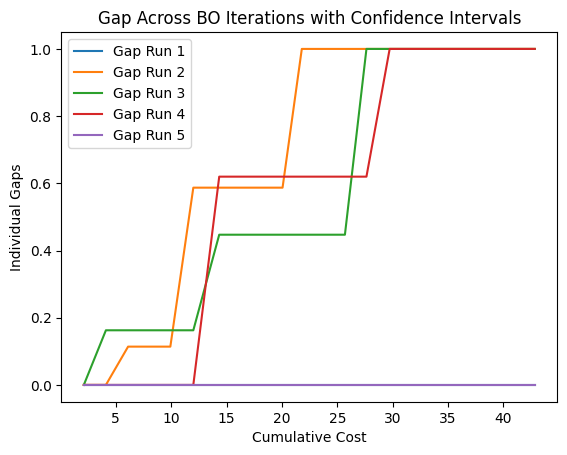

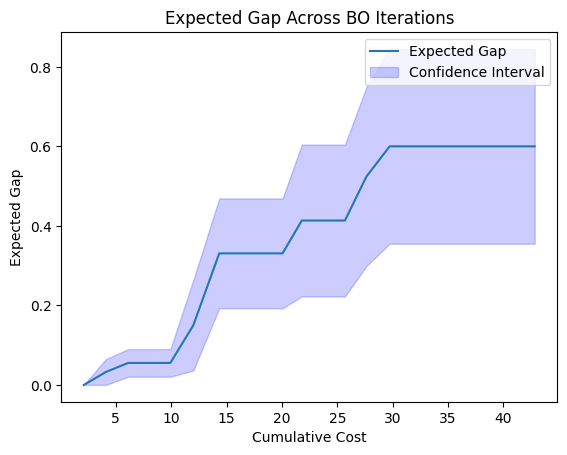

Expected Gap: tensor([[0.0000],
        [0.0325],
        [0.0553],
        [0.0553],
        [0.0553],
        [0.1499],
        [0.3308],
        [0.3308],
        [0.3308],
        [0.3308],
        [0.4134],
        [0.4134],
        [0.4134],
        [0.5240],
        [0.6000],
        [0.6000],
        [0.6000],
        [0.6000],
        [0.6000],
        [0.6000],
        [0.6000]], dtype=torch.float64)


In [ ]:
import matplotlib.pyplot as plt

# Plot individual gap runs
for i, gap_run in enumerate(gap_runs):
    plt.plot(times_ei_cost, gap_run, label=f"Gap Run {i+1}")

plt.xlabel("Cumulative Cost")
plt.ylabel("Individual Gaps")
plt.title("Gap Across BO Iterations with Confidence Intervals")
plt.legend()
plt.show()

# Plot the expected gap with confidence intervals
plt.plot(times_ei_cost, expected_gap, label="Expected Gap")
y1 = (expected_gap - std_dev / (n ** 0.5)).view(-1).tolist()
y2 = (expected_gap + std_dev / (n ** 0.5)).view(-1).tolist()
plt.fill_between(times_ei_cost.squeeze(1), y1, y2,
                 color='b', alpha=0.2, label="Confidence Interval")
plt.xlabel("Cumulative Cost")
plt.ylabel("Expected Gap")
plt.title("Expected Gap Across BO Iterations")
plt.legend()
plt.show()

print("Expected Gap:", expected_gap)


In [ ]:
def measure_gap(initial_minimum, min_observation, global_minimum):
    numerator = initial_minimum - min_observation
    denominator = initial_minimum - global_minimum
    if denominator == 0:
        return 1
    return numerator / denominator

# Initialize storage for gaps
dimensions = range(2, 4)
gaps_by_dimension_two_step = {}
gaps_by_dimension_one_step = {}

# Run the optimization for each dimension and record gaps for both methods
for dim in dimensions:
    # Update bounds for the current dimension
    bounds = torch.tensor([[0] * dim, [1] * dim], **tkwargs)
    initial_size = 10

    # Generate initial training data
    train_X = draw_sobol_samples(bounds=bounds, n=initial_size, q=1).squeeze(1)
    train_Y, cost_Y = synthetic_objective_with_cost(train_X)
    initial_minimum = train_Y.min().item()

    # Two-step lookahead Bayesian Optimization
    train_X_two_step, results_two_step, times_two_step, accum_cost_two_step, global_minimum_two_step = bayesian_optimization_with_cost(
        init_X=train_X,
        init_Y=train_Y,
        init_C=cost_Y,
        objective=synthetic_objective_with_cost,
        cost_model_class=CostModelGP,
        budget=10,
        bounds=bounds,
        initial_size=initial_size,
        tkwargs=tkwargs,
        horizon=2,  # Two-step lookahead
    )

    # One-step Bayesian Optimization
    train_X_one_step, results_one_step, times_one_step, accum_cost_one_step, global_minimum_one_step = bayesian_optimization_with_cost(
        init_X=train_X,
        init_Y=train_Y,
        init_C=cost_Y,
        objective=synthetic_objective_with_cost,
        cost_model_class=CostModelGP,
        budget=10,
        bounds=bounds,
        initial_size=initial_size,
        tkwargs=tkwargs,
        horizon=1,  # Two-step lookahead
    )

    # Calculate gaps for two-step approach
    observed_cummin_two_step = results_two_step
    gaps_two_step = torch.empty_like(observed_cummin_two_step)
    for i, mini in enumerate(observed_cummin_two_step):
        gaps_two_step[i] = measure_gap(initial_minimum, mini.item(), global_minimum_two_step)
    gaps_by_dimension_two_step[dim] = gaps_two_step.numpy()

    # Calculate gaps for one-step approach
    observed_cummin_one_step = results_one_step
    gaps_one_step = torch.empty_like(observed_cummin_one_step)
    for i, mini in enumerate(observed_cummin_one_step):
        gaps_one_step[i] = measure_gap(initial_minimum, mini.item(), global_minimum_one_step)
    gaps_by_dimension_one_step[dim] = gaps_one_step.numpy()

# Plot gaps for one-step and two-step approaches
plt.figure(figsize=(12, 8))
for dim in dimensions:
    plt.plot(range(1, len(gaps_by_dimension_two_step[dim]) + 1), gaps_by_dimension_two_step[dim], label=f"Two-Step {dim}D")
    plt.plot(range(1, len(gaps_by_dimension_one_step[dim]) + 1), gaps_by_dimension_one_step[dim], '--', label=f"One-Step {dim}D")

plt.title("Relative Gap Comparison: One-Step vs Two-Step (1-5D Ackley Function)")
plt.xlabel("Optimization Iteration")
plt.ylabel("Relative Gap")
plt.legend(title="Approach and Dimension")
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.0311], dtype=torch.float64), mean = tensor([2.3414], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.1349], dtype=torch.float64), mean = tensor([2.0642], dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:268: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([2.0623], dtype=torch.float64), mean = tensor([1.9686], dtype=torch.float64)).Please consider scaling the inpu

NameError: name 'plt' is not defined

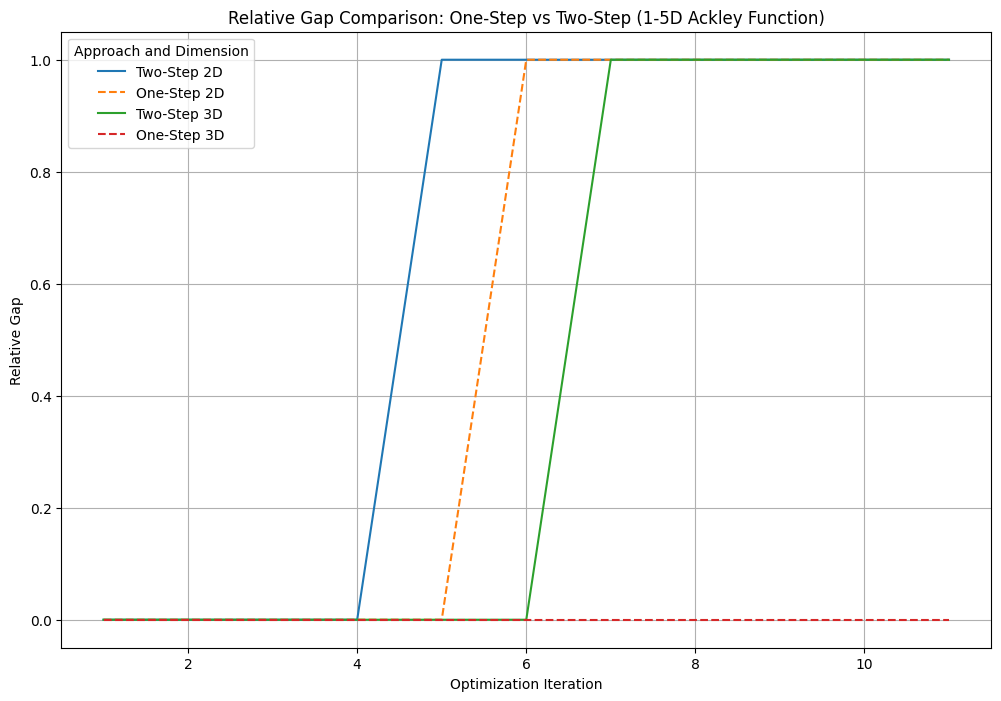

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for dim in dimensions:
    plt.plot(range(1, len(gaps_by_dimension_two_step[dim]) + 1), gaps_by_dimension_two_step[dim], label=f"Two-Step {dim}D")
    plt.plot(range(1, len(gaps_by_dimension_one_step[dim]) + 1), gaps_by_dimension_one_step[dim], '--', label=f"One-Step {dim}D")

plt.title("Relative Gap Comparison: One-Step vs Two-Step (1-5D Ackley Function)")
plt.xlabel("Optimization Iteration")
plt.ylabel("Relative Gap")
plt.legend(title="Approach and Dimension")
plt.grid(True)
plt.show()